In [84]:
import pandas as pd
from src.core.Processing import Processing
from src.core.Analyser import Analyser
from matplotlib import pyplot as plt
import numpy as np
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [85]:
file_path="/home/khaldi/Documents/data_app_machine/creditcard.csv"
sep=","
outcome="Class"
positive_mod="1"

In [86]:
df=pd.read_csv(file_path,sep=sep)

In [87]:
process=Processing() # object which do processing for df
analyzer=Analyser() #object which give graphics, statistics indicators for df

In [88]:
df.shape

(284807, 31)

In [89]:
process.summary(df)

{'Missing Values': Time      0
 V1        0
 V2        0
 V3        0
 V4        0
 V5        0
 V6        0
 V7        0
 V8        0
 V9        0
 V10       0
 V11       0
 V12       0
 V13       0
 V14       0
 V15       0
 V16       0
 V17       0
 V18       0
 V19       0
 V20       0
 V21       0
 V22       0
 V23       0
 V24       0
 V25       0
 V26       0
 V27       0
 V28       0
 Amount    0
 Class     0
 dtype: int64,
 'Constant Features': []}

In [90]:
df[outcome]=df[outcome].astype(str) # cast outcome to qualitative variable

the dimension of df is (284807,31)
We can see that they don't have any missing values and constant features

0    0.998273
1    0.001727
Name: Class, dtype: float64

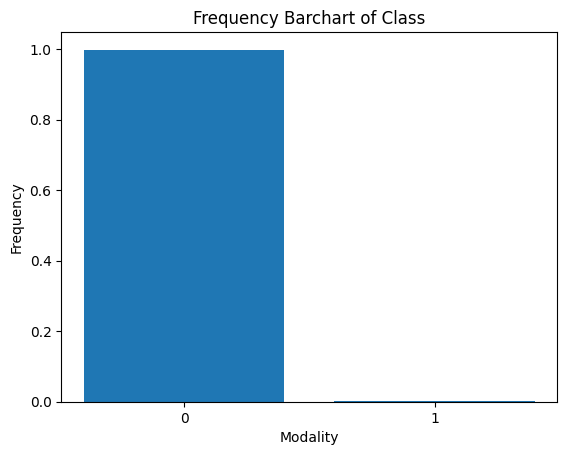

In [91]:
fig,ax=plt.subplots()
analyzer.bar_chart(df,outcome,ax,with_proportion=True)

We can see above that, Class attribute is very imbalanced ( 0.998 for modality "0")

In [92]:
analyzer_summary=analyzer.summary(df)
quantitatives,qualitatives=analyzer_summary["features"]["quantitative_columns"],analyzer_summary["features"]["qualitative_columns"]

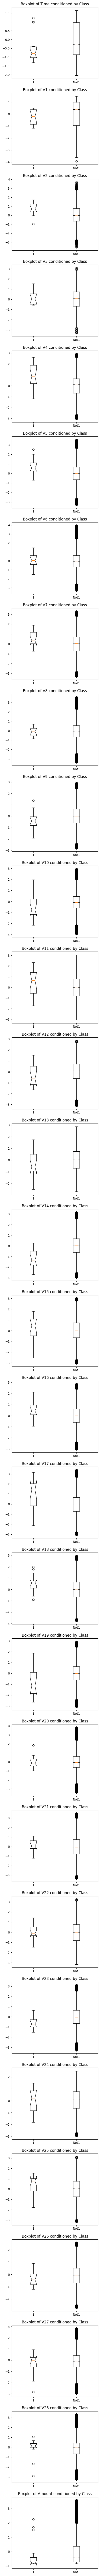

In [93]:
#we decided to remove outliers before boxplots creation
df=process.remove_outliers(df)
df[quantitatives]=process.standard_scaler(df[quantitatives]) #we also standardize quantitative features
fig,axs=plt.subplots(nrows=len(quantitatives),figsize=(5,len(quantitatives)*5))
for i in range(len(quantitatives)):
    analyzer.prop_churn_by_numerical_boxplot(df,outcome,positive_mod,quantitatives[i],axs[i])

- due to important numbers of features, we select variables with low, no influence for Class outcome:
    - Not/low influence: ["V22","V21","V19","V3"]

Conclusion -relevant quantitative features:
All except ["V22","V21","V19","V3"], to prevent overfitting risk, we are going to select a sub set of features most influents for Class outcome

In [94]:
relevant_features=list(set(quantitatives).difference({"V22","V21","V19","V3"}))
df_new=df[[outcome]+relevant_features] #we decided to work with only relevant features for Attrition

<Axes: >

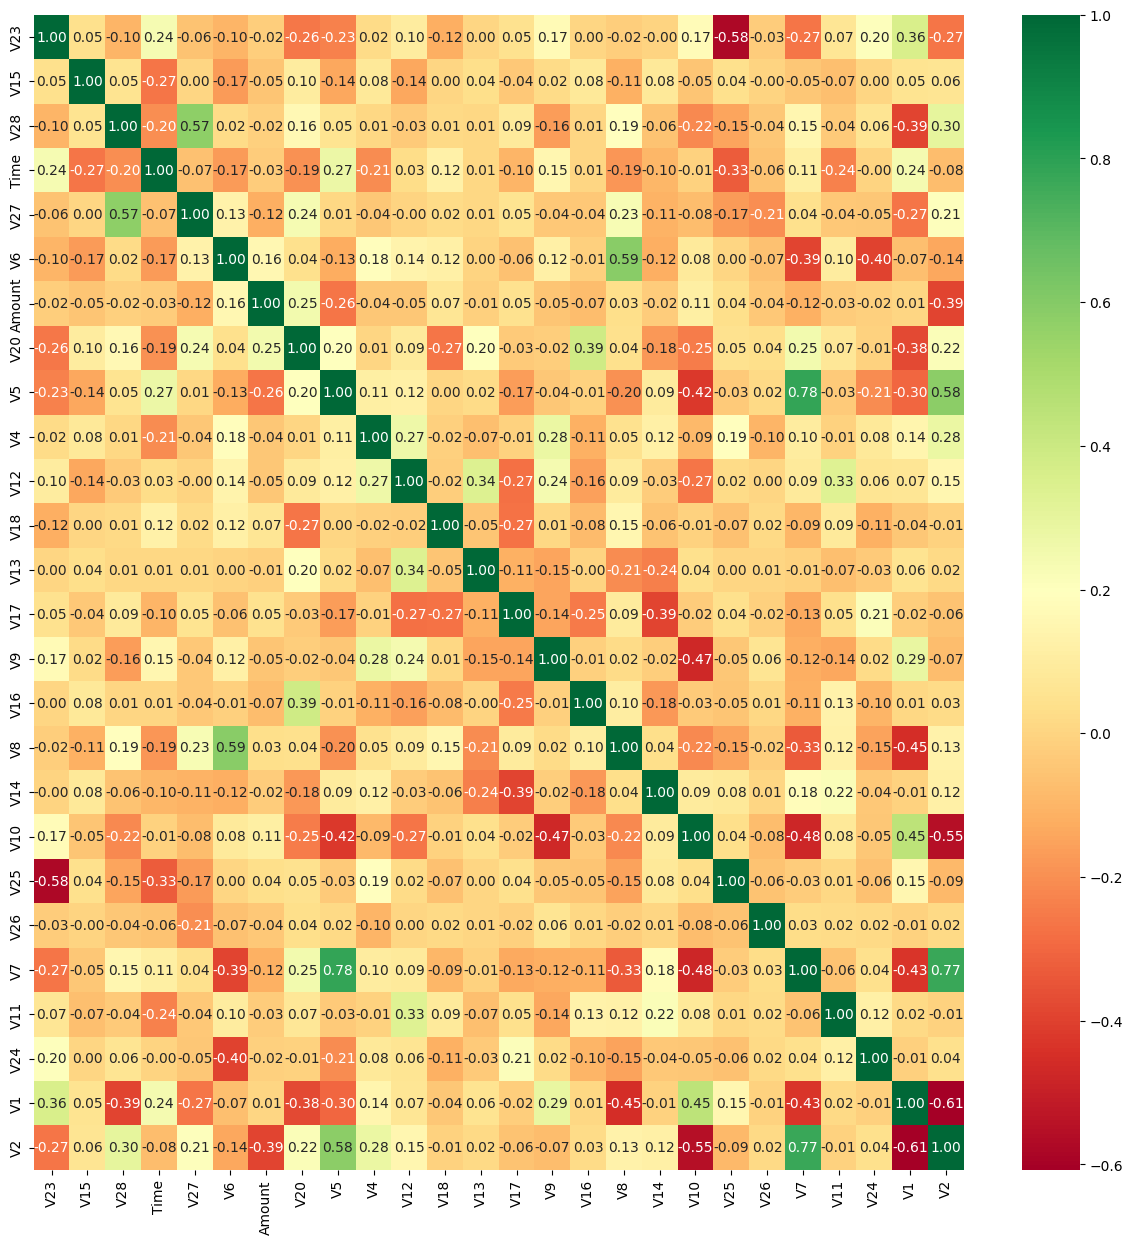

In [95]:
plt.figure(figsize=(15,15))
analyzer.correlation_heatmap(df_new,annot=True)

In [96]:
correlations=df_new.corr(numeric_only=True)
groups={1:.3,2:.5,3:.5}
"""
high correlation (>=.5): group3
medium correlation (>=.3 and <.5): group2
low correlation (<.3):group1
"""
print()

In [97]:
dict_correlations={key:[] for key in groups.keys()}
for group in groups.keys():
    if group==1:
        rows, cols =np.where(np.abs(correlations) < groups[group])
    elif group==2:
        rows, cols =np.where((np.abs(correlations) < groups[group]) & (np.abs(correlations) >= groups[group-1]))
    elif group==3:
        rows, cols =np.where(np.abs(correlations) >= groups[group])
    dict_correlations[group]=[(correlations.index[row], correlations.columns[col], correlations.iloc[row, col]) \
                              for row, col in zip(rows, cols) if row != col]

In [98]:
{
    group_number: dict_correlations[group_number]
        for group_number in dict_correlations.keys()
}

{1: [('V23', 'V15', 0.04535927800514511),
  ('V23', 'V28', -0.10229455295052675),
  ('V23', 'Time', 0.2390504407214811),
  ('V23', 'V27', -0.05566863611847013),
  ('V23', 'V6', -0.1002812469773107),
  ('V23', 'Amount', -0.017704959261646783),
  ('V23', 'V20', -0.2613882733591396),
  ('V23', 'V5', -0.23467759571346905),
  ('V23', 'V4', 0.02077002203614925),
  ('V23', 'V12', 0.09615235267457449),
  ('V23', 'V18', -0.12206242877850525),
  ('V23', 'V13', 0.0029857123445790005),
  ('V23', 'V17', 0.049259150448679526),
  ('V23', 'V9', 0.16897489996825596),
  ('V23', 'V16', 0.0016613234930096176),
  ('V23', 'V8', -0.02060650195116846),
  ('V23', 'V14', -0.0017673394273470162),
  ('V23', 'V10', 0.17498342973051872),
  ('V23', 'V26', -0.02537943900360794),
  ('V23', 'V7', -0.2654139512115227),
  ('V23', 'V11', 0.06915871640217881),
  ('V23', 'V24', 0.20373955775471048),
  ('V23', 'V2', -0.26571559288241103),
  ('V15', 'V23', 0.04535927800514511),
  ('V15', 'V28', 0.052867693130307904),
  ('V15'

We can see that this tuple features have abs(correlation)>=.5
[
  ('V23', 'V25', -0.5812886668266443),
  ('V1', 'V2', -0.607644959168512),
  ('V8', 'V6', 0.5861803360059155),
  ('V28', 'V27', 0.5736721045524082),
  ('V5', 'V2', 0.5841723999780843),
  ('V5', 'V7', 0.7820080661264317),
  ('V2', 'V10', -0.5535632809828112),
  ('V2', 'V7', 0.7692226619224113)
]
We decided to remove ["V23","V1","V8","V27","V5","V2"] to avoid as much as possible correlations between features

In [99]:
removed_features=["V23","V1","V8","V27","V5","V2"]
relevant_features=[f for f in relevant_features if f not in removed_features]
df_new_=df_new[[outcome]+relevant_features]

In [100]:
process.summary(df_new_)

{'Missing Values': Class     0
 V15       0
 V28       0
 Time      0
 V6        0
 Amount    0
 V20       0
 V4        0
 V12       0
 V18       0
 V13       0
 V17       0
 V9        0
 V16       0
 V14       0
 V10       0
 V25       0
 V26       0
 V7        0
 V11       0
 V24       0
 dtype: int64,
 'Constant Features': []}

In [101]:
analyzer.summary(df_new_)

{'features': {'qualitative_columns': ['Class'],
  'quantitative_columns': ['V15',
   'V28',
   'Time',
   'V6',
   'Amount',
   'V20',
   'V4',
   'V12',
   'V18',
   'V13',
   'V17',
   'V9',
   'V16',
   'V14',
   'V10',
   'V25',
   'V26',
   'V7',
   'V11',
   'V24']},
 'describe':                 V15           V28          Time            V6        Amount  \
 count  1.463340e+05  1.463340e+05  1.463340e+05  1.463340e+05  1.463340e+05   
 mean   2.175319e-17 -3.107599e-18 -1.243039e-17 -4.506018e-17 -6.992097e-17   
 std    1.000003e+00  1.000003e+00  1.000003e+00  1.000003e+00  1.000003e+00   
 min   -3.047714e+00 -3.260569e+00 -2.043051e+00 -3.318753e+00 -8.343829e-01   
 25%   -6.611799e-01 -6.718029e-01 -8.623812e-01 -6.890752e-01 -7.296545e-01   
 50%    4.405784e-02 -2.592689e-03 -2.966045e-01 -9.941970e-02 -4.381844e-01   
 75%    7.299755e-01  4.175231e-01  9.576369e-01  6.012084e-01  3.611466e-01   
 max    3.018557e+00  3.330720e+00  1.650457e+00  3.942248e+00  3.577121e+

In [102]:
###END OF SESSION 1

In [103]:
from src.core.ComputeModel import ComputeModel
from src.globals import MODEL_HYPERPARAMETERS_DEF
import copy

positive_mod="1"
models={"Logistic Regression":None,
        "SVM":None,
        "DecisionTreeClassifier":None
        }

In [104]:
#we use liblinear solver because Gradient descent doesn't converge for Logistic Regression
for model_name in models.keys():
    if model_name == "Logistic Regression":
        hyperparameters=copy.deepcopy(MODEL_HYPERPARAMETERS_DEF[model_name])
        hyperparameters["solver"]="liblinear"
    else:
        hyperparameters=None
    models[model_name]=ComputeModel(df_new_[relevant_features],df_new_[outcome], \
                                    process=process,model_name=model_name,\
                                    hyperparameters=hyperparameters,positive_mod=positive_mod,stratify=False)
    models[model_name].fit()

/home/khaldi/.cache/pypoetry/virtualenvs/app-machine-WNt7oxYU-py3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/khaldi/.cache/pypoetry/virtualenvs/app-machine-WNt7oxYU-py3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


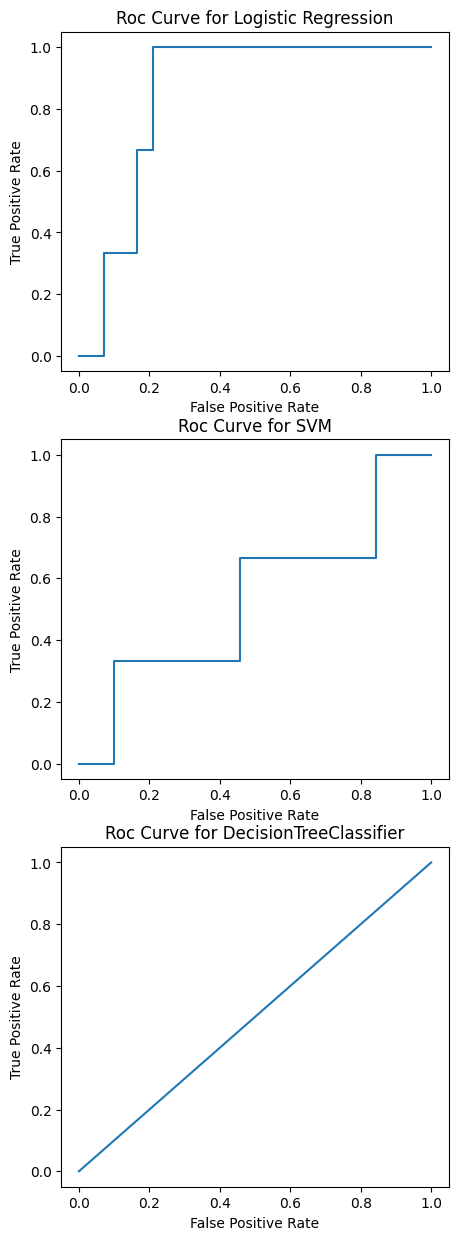

In [105]:
fig,axs=plt.subplots(nrows=len(models.keys()),figsize=(5,5*len(models.keys())))
metrics_default={list(models.keys())[i]:models[list(models.keys())[i]].metrics(plot_roc=True,ax=axs[i]) for i in range(len(models.keys()))}

In [106]:
metrics_default

{'Logistic Regression': {'auc': 0.8511937306360489,
  'accuracy': 0.9998974954727167,
  'precision': 0.0,
  'recall': 0.0,
  'f1_score': 0.0},
 'SVM': {'auc': 0.533465463823583,
  'accuracy': 0.9998974954727167,
  'precision': 0.0,
  'recall': 0.0,
  'f1_score': 0.0},
 'DecisionTreeClassifier': {'auc': 0.4999145708037179,
  'accuracy': 0.9997266545939112,
  'precision': 0.0,
  'recall': 0.0,
  'f1_score': 0.0}}

In conclusion:
we set up three models, DecisionTreeClassifier, SVM, Logistic Regression:
we use AUC metrics because it's metrics that allow to see False positive Rate and True Positive Rate, and as dataset is imbalanced, accuracy in this case is not relevant
- We can see that  Logistic Regression is the best model because AUC of this model (~0.85) is significantly bigger than auc for 2 others models
- We can see that probabity to be positive is very very low, consequently recall and precision are equal to 0 because dataset is very very imbalanced (~99.8% negative ~0.02% positive)
- To conclude, models are not efficient for this dataset, we need to have a oversampling/undersampling methods to balanced majority and minority class for Class outcome, we have decided to actualy work with imbalanced dataset in this sequence because in sequence 4, we will see over/under sampling methods
- Simplify conclusion: Logistic Regression > SVM > DecisionTreeClassifier (with default hyperparameters)




In [107]:
params_grid= \
    {
        "Logistic Regression": \
            {
                "penalty": ["l2"],
                "C": np.logspace(-3, 3, 7),
                "solver": ["lbfgs"],
                "multi_class": ["auto"],
                "n_jobs": [None],
                "max_iter": [200,250]
            },
        "SVM":
            {
                "kernel": ["poly", "rbf", "sigmoid"],
                "C": [0.1, 1, 10, 100],
                "degree": [3],
                "gamma": [1, 0.1, 0.01, 0.001]

            },
        "DecisionTreeClassifier":
            {
                "criterion": ["gini"],
                "splitter": ["best"],
                "max_depth": [None],
                "min_samples_split": [2, 3, 4],
                "min_samples_leaf": [1],
                "min_weight_fraction_leaf": [0.],
                "max_features": [None],
                "random_state": [None],
                "max_leaf_nodes": [None]+list(range(2, 100)),
                "min_impurity_decrease": [0.],
                "class_weight": [None],
                "ccp_alpha": [0.]
            }

    }


In [108]:
#we used 3 fold cross validation with a params default grid located in globals file (in src directory)
for model_name in models.keys():
    models[model_name]=ComputeModel(df_new_[relevant_features],df_new_[outcome], \
                                    process=process,model_name=model_name,\
                                    positive_mod=positive_mod,grid_search=True,cv=3,params_grid=params_grid[model_name],stratify=False)
    models[model_name].fit()

Fitting 3 folds for each of 14 candidates, totalling 42 fits
Fitting 3 folds for each of 48 candidates, totalling 144 fits
Fitting 3 folds for each of 297 candidates, totalling 891 fits


/home/khaldi/.cache/pypoetry/virtualenvs/app-machine-WNt7oxYU-py3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/khaldi/.cache/pypoetry/virtualenvs/app-machine-WNt7oxYU-py3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/khaldi/.cache/pypoetry/virtualenvs/app-machine-WNt7oxYU-py3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter t

{'Logistic Regression': {'auc': 0.5720794605431019,
  'accuracy': 0.9998974954727167,
  'precision': 0.0,
  'recall': 0.0,
  'f1_score': 0.0},
 'SVM': {'auc': 0.7465600510297066,
  'accuracy': 0.9998974954727167,
  'precision': 0.0,
  'recall': 0.0,
  'f1_score': 0.0},
 'DecisionTreeClassifier': {'auc': 0.4994190814652816,
  'accuracy': 0.9998974954727167,
  'precision': 0.0,
  'recall': 0.0,
  'f1_score': 0.0}}

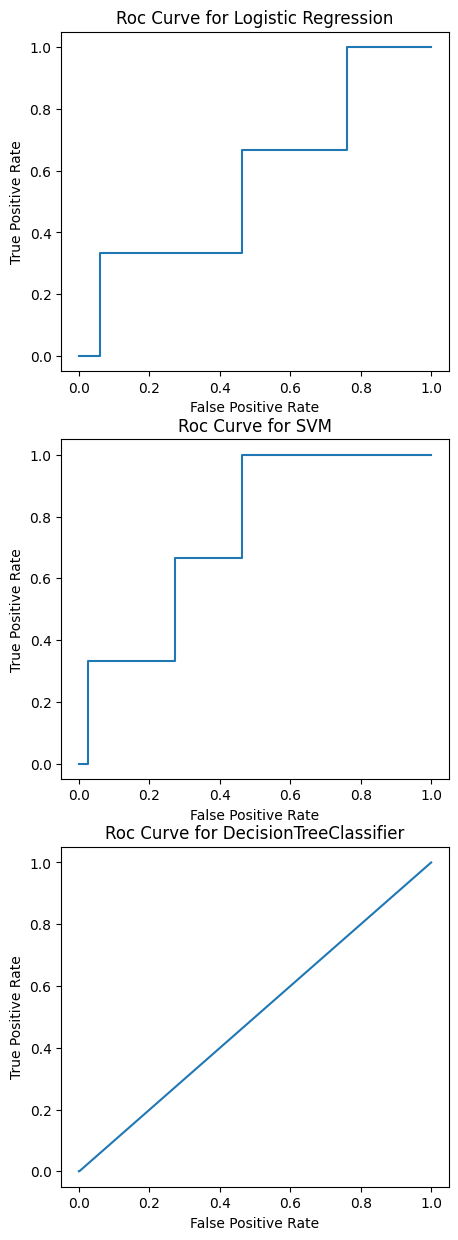

In [109]:
fig,axs=plt.subplots(nrows=len(models.keys()),figsize=(5,5*len(models.keys())))
metrics={list(models.keys())[i]:models[list(models.keys())[i]].metrics(plot_roc=True,ax=axs[i]) for i in range(len(models.keys()))}
metrics

In [110]:
resume_tuned=pd.DataFrame(metrics)
resume_default=pd.DataFrame(metrics_default)

In [111]:
pd.concat([resume_tuned.T,resume_default.T])\
    .reset_index()\
    .groupby("index")\
    .agg(lambda x:[a for a in x])
#first component of tuple is indicator for hyperparameters tuning

,auc,accuracy,precision,recall,f1_score
index,,,,,
DecisionTreeClassifier,"[0.4994190814652816, 0.4999145708037179]","[0.9998974954727167, 0.9997266545939112]","[0.0, 0.0]","[0.0, 0.0]","[0.0, 0.0]"
Logistic Regression,"[0.5720794605431019, 0.8511937306360489]","[0.9998974954727167, 0.9998974954727167]","[0.0, 0.0]","[0.0, 0.0]","[0.0, 0.0]"
SVM,"[0.7465600510297066, 0.533465463823583]","[0.9998974954727167, 0.9998974954727167]","[0.0, 0.0]","[0.0, 0.0]","[0.0, 0.0]"


- We can see that SVM are significantly improve in term of performance (auc: 0.533 to .746), DecisionTreeClassifier stay at the same order of values.
  But with tuning, LogisticRegression, auc decrease, accuracy stay constant (.99), precision, recall, f1_score stay equal to 0
- An important things: metrics after tuning are more reliable because a 3 fold cross validation are set up during training whereas with default hyperparameters this 3 cross validation was not done (1 test set and 1 training set), that's why some indicators don't increase after tuning.
- Conclusion: even if you are using grid search, the best model for each three type of model don't resolve the problem of imbalance dataset;
  We need to equilibrate dataset and after train a model, I think that they are a huge imbalance between majority and minority modality for Class outcome
  and consequently all 3 models don't see minority class and predict always majority class.
  SVM with 3 cross validation (auc~0.746) seems be the best of all models trained.

In [112]:
hyperparameters_tuned={list(models.keys())[i]:models[list(models.keys())[i]].model.hyperparameters for i in range(len(models.keys()))}

In [113]:
hyperparameters_tuned

{'Logistic Regression': {'C': 0.001,
  'max_iter': 200,
  'multi_class': 'auto',
  'n_jobs': None,
  'penalty': 'l2',
  'solver': 'lbfgs'},
 'SVM': {'C': 0.1, 'degree': 3, 'gamma': 1, 'kernel': 'rbf'},
 'DecisionTreeClassifier': {'ccp_alpha': 0.0,
  'class_weight': None,
  'criterion': 'gini',
  'max_depth': None,
  'max_features': None,
  'max_leaf_nodes': 2,
  'min_impurity_decrease': 0.0,
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'min_weight_fraction_leaf': 0.0,
  'random_state': None,
  'splitter': 'best'}}

In [114]:
best_model,hyperparameters_best=models["SVM"],hyperparameters_tuned["SVM"]

In [115]:
###END OF SESSION 2

In [116]:
model_random=ComputeModel(df_new_[relevant_features],df_new_[outcome], \
                          process=process,model_name="RandomForestClassifier", \
                          positive_mod=positive_mod,grid_search=True)
model_random.fit()

Fitting 3 folds for each of 25 candidates, totalling 75 fits


In [117]:
model_random.metrics() #Random forest is not better than SVM (auc ~0.64)

/home/khaldi/.cache/pypoetry/virtualenvs/app-machine-WNt7oxYU-py3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'auc': 0.6594906141789685,
 'accuracy': 0.9998974954727167,
 'precision': 0.0,
 'recall': 0.0,
 'f1_score': 0.0}

In [118]:
from matplotlib import pyplot
hyperparameters_best={'C': 0.1, 'degree': 3, 'gamma': 1, 'kernel': 'rbf'}

In [119]:
best_model=ComputeModel(df_new_[relevant_features],df_new_[outcome], \
              process=process,model_name="SVM", \
              positive_mod=positive_mod,stratify=False,hyperparameters=hyperparameters_best)

In [120]:
best_model.fit()

In [121]:
best_model.metrics()

/home/khaldi/.cache/pypoetry/virtualenvs/app-machine-WNt7oxYU-py3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'auc': 0.7465600510297066,
 'accuracy': 0.9998974954727167,
 'precision': 0.0,
 'recall': 0.0,
 'f1_score': 0.0}

In [122]:
results_perm=best_model.permutation_importance_model()

Feature: V15, Score: 0.03142126920393547
Feature: V28, Score: 0.013127162445004536
Feature: Time, Score: 0.0509313285777341
Feature: V6, Score: -0.0012478464539461332
Feature: Amount, Score: 0.04130722025258773
Feature: V20, Score: -0.03063332051884442
Feature: V4, Score: 0.03323451938547406
Feature: V12, Score: 0.0018618028562072731
Feature: V18, Score: 0.016903449945182537
Feature: V13, Score: 0.06526461919610431
Feature: V17, Score: 0.0021760426010564602
Feature: V9, Score: -0.01627240755770083
Feature: V16, Score: 0.016618398758418397
Feature: V14, Score: 0.061369584098643036
Feature: V10, Score: 0.0066814745205245885
Feature: V25, Score: 0.05169165492005179
Feature: V26, Score: 0.029805789301325603
Feature: V7, Score: -0.016648156849344398
Feature: V11, Score: 0.01340779975225317
Feature: V24, Score: 0.03389546224709179


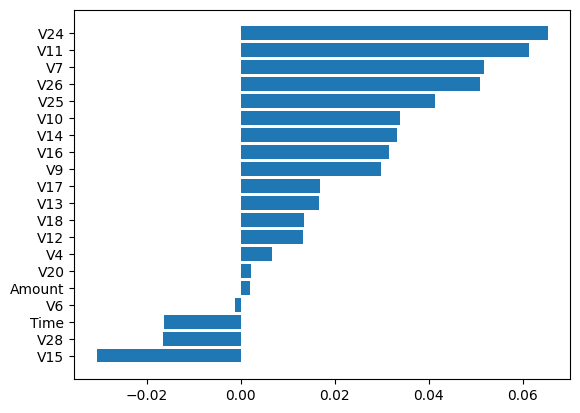

<Figure size 640x480 with 0 Axes>

In [123]:
importance = results_perm.importances_mean
indices = np.argsort(importance)
# summarize feature importance
for i,v in enumerate(importance):
    print(f"Feature: {best_model.dict_split['columns_features'][i]}, Score: {v}")
# plot feature importance
pyplot.barh([best_model.dict_split['columns_features'][x] for x in range(len(indices))], importance[indices])
pyplot.show()
plt.tight_layout()

most 10 influent features : "V24", "V11", "V7", "V26", "V25", "V10", "V14","V16","V9","V17"

In [124]:
relevant_features_top10=["V24","V11","V7","V26","V25","V10","V14","V16","V9","V17"]

model_top10=ComputeModel(df_new_[relevant_features_top10],df_new_[outcome], \
                        process=process,model_name="SVM",stratify=False, \
                        positive_mod=positive_mod,hyperparameters=hyperparameters_best)

In [125]:
model_top10.fit()

In [126]:
model_top10.metrics()

/home/khaldi/.cache/pypoetry/virtualenvs/app-machine-WNt7oxYU-py3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'auc': 0.3053581191908146,
 'accuracy': 0.9998974954727167,
 'precision': 0.0,
 'recall': 0.0,
 'f1_score': 0.0}

We can see that the dataset is too imbalanced, even if we select top 10 influent features, auc decrease significantly (0.75 to 0.3).
We need to balance the dataset. But I think that SVM capture better informations with hyperparameters tuning than others model

In [127]:
model_seq3=best_model

In [128]:
hyperparameters_best

{'C': 0.1, 'degree': 3, 'gamma': 1, 'kernel': 'rbf'}

In [129]:
model_seq3

In [130]:
###END OF SESSION 3